## Lennard-Jones parameterization relies on physical properties

Since the earliest days of force field science, LJ parameters have been fitted against physical property datasets ( typically liquid densities and heats of vaporization). This is an important step of parameterization because it fits the critical LJ parameters and introduces macroscopic constraints that complement microscopic QM constraints.

The disadvantage of using physical property measurements in parameterization is that they are generally slow to evaluate, because computing a physical property with a force field requires you to run an equilibrium simulation with that force field. This makes it difficult to efficiently optimize LJ parameters or otherwise explore parameter space due to computational constraints.

## Bayesian posterior sampling is a promising method of exploring parameter space

Bayesian inference is a paradigm for evaluating parameter sets that naturally incorporates prior information and a likelihood derived from experimental data into a posterior distribution, which can be used as a metric for fitness. Bayesian inference is of interest to us because of a) the way that it parsimoniously incorporates previous model knowledge, and b) because understanding the whole parameter distribution can find parameter sets that escape local minima.

The catch, however, is that evaluating a Bayesian posterior distribution generally requires Monte Carlo simulation, and is even more computationally expensive then most optimization schemes. So if we want to do Bayesian exploration of a parameter probability distribution, we need a way to speed things up significantly. For us, this means we need a much faster way of taking LJ parameter inputs (sigma/rmin_half, epsilon) and getting physical property outputs (densities, enthalpies) very quickly.

## We can accelerate sampling with surrogate modeling

Fortunately, the physical properties we are interested in are relatively smooth functions of the LJ parameters in our regions of interest, and can be approximated with simpler surrogate models with limited losses of fidelity. For our surrogate models, we can use Gaussian Processes, which are simple surrogates that excel at making predictions (with uncertainty) from a limited number of observations. The technique originated in geostatistics, where it is desirable to understand mineral content over a wide area of space, but only feasible to take a limited number of samples. The principle is the same here!

## Tutorial Objective
1. Starting from a set of simulations of liquid argon, build a Gaussian Process surrogate model that produces estimates of argon density (with uncertainty estimates) as a function of the Argon LJ parameters (epsilon, rmin_half)
2. Construct a Bayesian posterior distribution function over the Argon LJ parameters that evaluates the fitness of parameters.
3. Using MCMC sampling techniques, construct the posterior parameter distribution of the Argon LJ parameters.

### Building a surrogate model

We start by building a Gaussian Process surrogate model from a sampled dataset of Argon densities, simulated at 97.44 atm and 89.13 K.  The dataset consists of 20 density samples, with parameters selected with Latin Hypercube Sampling in the ranges epsilon = [0.1785.0.2975], rmin_half = [1.43,2.38]

First we load the relevant data.

In [2]:
path = '../../../data/argon_single_new_20'
smirks_types_to_change = ['[#18:1]']
forcefield = 'openff-1-3-0-argon.offxml'
dataset_json = 'argon_single.json'
device = 'cpu'

Now we can build a surrogate model, using the `botorch` surrogate modeling library, which is built on top of `GPytorch` (which is build on top of `torch`).  The details are somewhat obscured, but the code is available in the `surrogates` module.

In [3]:
from LJ_surrogates.surrogates.collate_data import collate_physical_property_data
dataplex = collate_physical_property_data(path, smirks_types_to_change, forcefield,
                                          dataset_json, device)

Started with 20 datasets, removed 0 empty dataset(s)
Removed 0 incomplete or errored datasets
Eliminating Bad Density Measurements...
Removed 0 datasets due to bad density measurments
Removing Low Energy Acetic Acid meaasurements
Removed 0 datasets due to low acetic acid hvap measurments
Proceeding to build surrogates with 20 Datasets


<Figure size 432x288 with 0 Axes>

It makes sense to look at some intermediate plots to understand what is happening here. First, the parameters that we sampled:

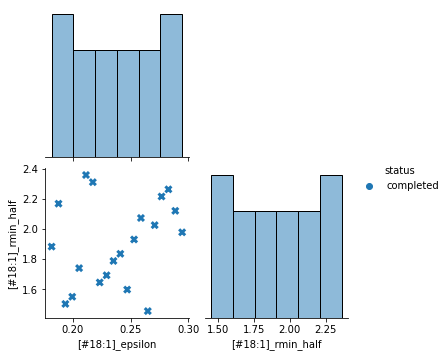

In [4]:
dataplex.plot_parameter_sets(show=True)

Then we can examine the property values associated with those parameter sets

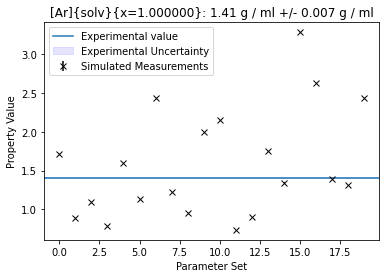

<Figure size 432x288 with 0 Axes>

In [5]:
dataplex.plot_properties(show=True)

Now, we will proceed to constructing a posterior distribution over the parameters.  The posterior distribution consists of a likelihood function that measures how far the surrogate density estimate is away from the experimental value.  This is accomplished with a normal distribution pdf that is centered at the experimental value, with sigma determined by a combination of the surrogate and experimental uncertainty.  There is also a prior distribution, which is our *a priori* estimate of what the prior distribution should look like.  This is represented by a normal distribution over parameter space, centered at the initial value, with sigma equal to 1/10th of the initial value.  This presumes that the most likely parameter values are the initial values, and any other values will have to surpass initial values in terms of predictive power to have a high posterior probability.  This is done with the `likelihood` module in the `LJ_surrogates` package.

In [6]:
from LJ_surrogates.sampling.likelihood import likelihood_function
likelihood = likelihood_function(dataplex, device)

We can then test the implementation to see how fast we can evaluate a set of parameters:

In [7]:
import time
import numpy as np
import torch
test_params = torch.tensor(np.asarray([0.25,1.9]).reshape(2, 1).transpose()).to(device=device).detach()

start = time.time()
predict_botorch_multi, stddev_botorch_multi = likelihood.evaluate_parameter_set_multisurrogate(test_params)
end = time.time()
print(f'Botorch Multi: {end - start} seconds')

Botorch Multi: 0.12394213676452637 seconds


As you can see, this runs very quickly.  To perform this calculation with simulations would take on the scale of minutes-hours.
Now, we can take samples from the posterior distribution through the use of MCMC samples.  Because we don't know what the distribution looks like beforehand, or where the best values will be, MCMC sampling provides a convenient way to proportionally sample the probability distribution.


In [8]:
import os
from pyro.infer.mcmc.util import summary
mcmc, initial_parameters = likelihood.sample(samples=1000, step_size=0.001, max_tree_depth=5, num_chains=1)
mcmc._samples['parameters'] = mcmc._samples['parameters'].cpu()
summary = summary(mcmc._samples)
params = mcmc.get_samples()['parameters'].cpu().flatten(end_dim=1).numpy()
params = np.append(params,initial_parameters.cpu().numpy(),axis=0)
ranges = dataplex.export_sampling_ranges()
sampled_ranges = []
for i in range(params.shape[1]):
    low_index = int(np.floor(0.025*len(params[:,i])))
    high_index = int(np.floor(0.975*len(params[:,i])))
    sorted_samples = sorted(params[:,i])
    sampled_ranges.append([sorted_samples[low_index],sorted_samples[high_index]])


# likelihood.evaluate_surrogate_gpflow(likelihood.surrogates[0],test_params)
os.makedirs(os.path.join('result', 'figures'), exist_ok=True)

Sample: 100%|██████████| 1200/1200 [00:53, 22.30it/s, step size=9.91e-02, acc. prob=0.930]


Now we can plot the 2D distribution as a triangle plot:

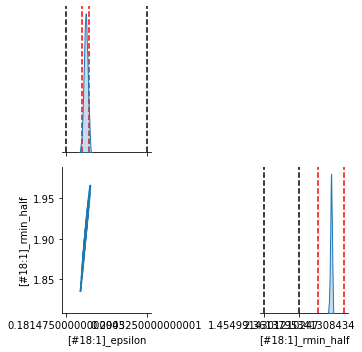

In [9]:
from LJ_surrogates.plotting.plotting import plot_triangle
plot_triangle(params, likelihood, ranges, None, 1000, show=True)

In order to get a better look at the surrogate surface we can make a grid of points to evaluate and then do a contour plot:

In [10]:
from LJ_surrogates.parameter_modification import create_evaluation_grid
grid = create_evaluation_grid(forcefield, smirks_types_to_change, np.array([0.75, 1.25]))


def grid_to_surrogate_2D(grid, surrogate):
    value_grid = np.empty((grid[0].shape[0], grid[0].shape[1]))
    uncertainty_grid = np.empty((grid[0].shape[0], grid[0].shape[1]))

    for i in range(grid[0].shape[0]):
        for j in range(grid[0].shape[1]):
            # val = surrogate(
            #     torch.tensor(np.expand_dims(np.asarray([grid[0][i, j], grid[1][i, j]]), axis=1).transpose()).cuda())
            val = surrogate(
                torch.tensor(np.expand_dims(np.asarray([grid[0][i, j], grid[1][i, j]]), axis=1).transpose()).to(device=device))
            value_grid[i, j] = val.mean
            uncertainty_grid[i, j] = val.stddev

    return value_grid, uncertainty_grid
expt_value = dataplex.properties.properties[0]._value.m
expt_uncertainty = dataplex.properties.properties[0]._uncertainty.m
expt_pressure = dataplex.properties.properties[0].thermodynamic_state.pressure.m
expt_temperature = dataplex.properties.properties[0].thermodynamic_state.temperature.m
value_grid, uncertainty_grid = grid_to_surrogate_2D(grid, dataplex.multisurrogate)

Plotting the surrogate values as deviation from experiment:

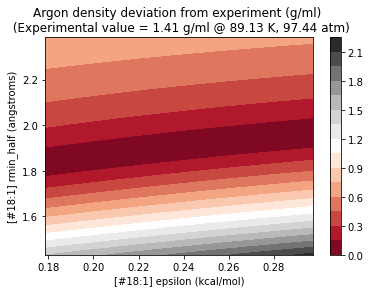

In [11]:
import matplotlib.pyplot as plt
plt.clf()
plt.contourf(grid[0], grid[1], abs(expt_value - value_grid), 20, cmap='RdGy')
plt.colorbar()
plt.xlabel('[#18:1] epsilon (kcal/mol)')
plt.ylabel('[#18:1] rmin_half (angstroms)')
plt.title(
    f'Argon density deviation from experiment (g/ml) \n (Experimental value = {expt_value} g/ml @ {expt_temperature} K, {expt_pressure} atm)')
plt.savefig(os.path.join('result/figures', f'surrogate_values_{expt_temperature}_K_{expt_pressure}_atm.png'),
            dpi=300)
plt.show()

We can also look at the quality of the surrogate, by plotting the surrogate uncertainties as a function of parameters:

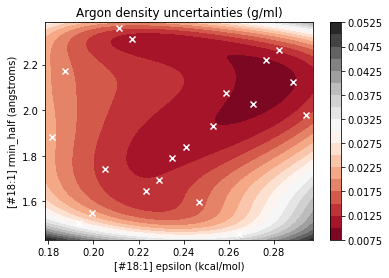

In [12]:
plt.contourf(grid[0], grid[1], uncertainty_grid, 20, cmap='RdGy')
plt.colorbar()
plt.scatter(dataplex.parameter_values.to_numpy()[:, 0], dataplex.parameter_values.to_numpy()[:, 1], color='1',
            marker='x')

plt.xlabel('[#18:1] epsilon (kcal/mol)')
plt.ylabel('[#18:1] rmin_half (angstroms)')
plt.title(
    f'Argon density uncertainties (g/ml)')
# plt.title('Latin Hypercube Sampling of argon LJ parameters')
plt.savefig(os.path.join('result/figures', f'surrogate_uncertainties_{expt_temperature}_K_{expt_pressure}_atm.png'),
            dpi=300)
plt.show()

In this we can see that the surrogate is doing a good job of reproducing accurate estimates of the density of argon.  The samples used to generate the surrogate are shown as x's.  Note that regions with higher density of samples tend to have better surrogate accuracy.